# 3D volume rendering of geophysical data using the yt platform

A notebook submission to the 2020 EarthCube Annual Meeting

**Authors**: Christopher Havlin<sup>1</sup>,  Benjamin Holtzman<sup>1</sup>, Kacper Kowalik<sup>2</sup>, Madicken Munk<sup>2</sup>, Sam Walkow<sup>2</sup>, Matthew Turk<sup>2</sup> 

1. Lamont-Doherty Earth Observatory, Columbia University 
2. University of Illinois Urbana-Champagne 

###  Introduction

re-hash the abstract 

**the data** a brief description of the data: tomography, dvs.

### Overview of Notebook

overview of what this notebook does exactly


We begin by importing the libraries and setting required environment variables. In addition to the standard `yt` library, the present notebook relies on a supplementary `yt_seismic` library (https://github.com/chrishavlin/yt_seismic, the home of the present notebook) that facilates data loading and transformations as described below.

In [4]:
# imports and initialization 
import os, yt, numpy as np
import matplotlib.pyplot as plt
from yt_velmodel_vis import seis_model as SM,shapeplotter as SP, transferfunctions as TFs
os.environ['YTVELMODELDIR']='./data' # local repo path to data directory (do not change)

## Loading IRIS Earth Model Collaboration (EMC) Files

Overwview of types of files/meshes yt works well with. 


### Loading IRIS EMC Files: loading the files 

IRIS EMC files are standardized netcdf files with geophysical data in geo-spherical coordinates (latitude, longitude and depth).

#### Interpolation 
At present, 3D volume rendering in yt is restricted to cartesian coordinates. A spherical rendering module is in development, but for the current demonstration we must interpolate from spherical to cartesian coordinates. 

Given that the interpolation from spherical to cartesian coordinates is computationally intense, the current notebook loads a single pre-built interpolation included in the respository data directory (`./data/`) for the regional tomography study of CITATATION, covering the Northwest United States. 

In [5]:
# load the pre-built interpolated model
datafld='dvs'    
interp_dict={'field':'dvs','max_dist':50000,'res':[10000,10000,10000],
              'input_units':'m','interpChunk':int(1e7)}
model=SM.netcdf('NWUS11-S_percent.nc',interp_dict)
bbox = model.cart['bbox'] # the bounding box of interpolated grid
data={datafld:model.interp['data'][datafld]} # data container for yt scene

# load the data as a uniform grid, create the 3d scene
ds = yt.load_uniform_grid(data,data[datafld].shape,1.0,bbox=bbox,nprocs=1,
                        periodicity=(True,True,True),unit_system="mks")
print("Data loaded.")

yt : [INFO     ] 2020-05-07 13:17:09,738 Parameters: current_time              = 0.0
yt : [INFO     ] 2020-05-07 13:17:09,739 Parameters: domain_dimensions         = [287 271 237]
yt : [INFO     ] 2020-05-07 13:17:09,740 Parameters: domain_left_edge          = [-5201282.   -3445670.25  2740212.5 ]
yt : [INFO     ] 2020-05-07 13:17:09,741 Parameters: domain_right_edge         = [-2328344.5     -735306.5625  5113796.5   ]
yt : [INFO     ] 2020-05-07 13:17:09,742 Parameters: cosmological_simulation   = 0.0


Data loaded.


### Loading IRIS EMC Files: Building the scene 

After loading the data, we create a function that returns an active yt scene. This is the initial 3D view, including latitude and longitude grids, tectonic boundaries and volcanos at the sruface of the earth. Similar to the initial data load, the `yt_semisic.shapeplotter` module contains transformations from geo-spherical coordinates to geocetnric cartesian coordinates with automatic processing of shapefiles. 

In [6]:
def build_yt_scene():

    sc = yt.create_scene(ds,datafld)

    # Draw the domain boundary and useful grids
    lat_rnge=[np.min(model.data.variables['latitude']),np.max(model.data.variables['latitude'])]
    lon_rnge=[np.min(model.data.variables['longitude']),np.max(model.data.variables['longitude'])]
    min_dep=0.
    max_dep=1200.
    R=6371.
    r_rnge=[(R-max_dep)*1000.,(R-min_dep)*1000.]
    Chunk=SP.sphericalChunk(lat_rnge,lon_rnge,r_rnge)
    sc=Chunk.domainExtent(sc,RGBa=[1.,1.,1.,0.002],n_latlon=100,n_rad=50)
    sc=Chunk.latlonGrid(sc,RGBa=[1.,1.,1.,0.005])
    sc=Chunk.latlonGrid(sc,RGBa=[1.,1.,1.,0.002],radius=(R-410.)*1000.)
    sc=Chunk.latlonGrid(sc,RGBa=[1.,1.,1.,0.002],radius=(R-max_dep)*1000.)
    sc=Chunk.wholeSphereReference(sc,RGBa=[1.,1.,1.,0.002])

    # Add shapefile data
    shp_bbox=[lon_rnge[0],lat_rnge[0],lon_rnge[1],lat_rnge[1]]

    for shpfi in ['us_states']:
        thisshp=SP.shapedata(shpfi,bbox=shp_bbox,radius=R*1000.)
        sc=thisshp.addToScene(sc)

    clrs={
        'transform':[0.8,0.,0.8,0.05],
        'ridge':[0.,0.,0.8,0.05],
        'trench':[0.8,0.,0.,0.05],
        'global_volcanos':[0.,0.8,0.,0.05]
    }
    for bound in ['transform','ridge','trench','global_volcanos']:
        tect=SP.shapedata(bound,radius=R*1000.,buildTraces=False)
        sc=tect.buildTraces(RGBa=clrs[bound],sc=sc,bbox=shp_bbox)
        
    return sc   



The view is controlled by the camera object of a scene. 

In [7]:
def setCamera(sc):
    pos=sc.camera.position
    Rmax=6371*1000.
    center_vec=np.array([np.mean(bbox[0])/Rmax,np.mean(bbox[1])/Rmax,np.mean(bbox[2])/Rmax])
    sc.camera.set_position(pos,north_vector=center_vec)

    res=sc.camera.get_resolution()
    res_factor=1
    new_res=(int(res[0]*res_factor),int(res[1]*res_factor))
    sc.camera.set_resolution(new_res)

    zoom_factor=0.7 # < 1 zooms in
    init_width=sc.camera.width
    sc.camera.width = (init_width * zoom_factor)
    sc.camera.rotate(0*np.pi/180)

## Transfer Functions

**Overview of 3D volume rendering in yt:** 3D volume rendering in yt is based on integration of RGB values along raypaths through the volume. Each voxel in the 3D space is assigned an RGB value and transmission coefficient that control how much an individual voxel contributes to the composite along the entire ray path. 




### Transfer Functions: yt presets

yt provides a variety of preset transfer functions. 


First, we define a simple function for plotting transfer functions on top of normalized histograms of the datafield being plotted.

In [8]:
def plotTf_yt(tf,dvs_min,dvs_max):     
    x = np.linspace(dvs_min,dvs_max,tf.nbins)
    y = tf.funcs[3].y
    w = np.append(x[1:]-x[:-1], x[-1]-x[-2])
    colors = np.array([tf.funcs[0].y, tf.funcs[1].y, tf.funcs[2].y,
                       tf.funcs[3].y]).T
    fig = plt.figure()
    ax = fig.add_axes([0.2, 0.2, 0.75, 0.75])
    d_hist=ax.hist(data['dvs'][~np.isnan(data['dvs'])].ravel(),bins=100,density=True,log=False,color='k')
    ax.bar(x, tf.funcs[3].y, w, edgecolor=[0.0, 0.0, 0.0, 0.0],
           log=False, color=colors, bottom=[0])
    plt.show()

And now, we illustrate several simple preset transfer functions

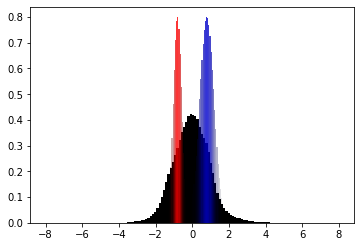

In [9]:
# initialize the tf object by setting the data bounds to consider
dvs_min=-8
dvs_max=8 
tf = yt.ColorTransferFunction((dvs_min,dvs_max))

# set gaussians
TF_gaussians=[
    {'center':-.8,'width':.1,'RGBa':(1.,0.,0.,.8)},
    {'center':.8,'width':.3,'RGBa':(0.,0.,0.8,.8)}
]
for gau in TF_gaussians:
    tf.add_gaussian(gau['center'],gau['width'],gau['RGBa'])
    
# plot the transfer function     
plotTf_yt(tf,dvs_min,dvs_max)

Once the transfer function is set, the volume rendering can be created. Because we will explore different transfer functions below, we first define athat builds the yt scene object. 

In [10]:
def configure_scene(the_transfer_function):
    # build scene, apply camera settings, set the transfer function 
    sc = build_yt_scene() 
    setCamera(sc)
    source = sc.sources['source_00']
    source.set_transfer_function(the_transfer_function)
    print("Scene ready to render")
    return sc

In [11]:
sc = configure_scene(tf)

Scene ready to render


The scene is now ready to render, which is done by calling `sc.show()`.

yt : [INFO     ] 2020-05-07 13:17:38,143 Rendering scene (Can take a while).
yt : [INFO     ] 2020-05-07 13:17:38,487 Creating volume
/home/chavlin/anaconda2/envs/yt_vis/lib/python3.8/site-packages/yt/units/yt_array.py:1396: RuntimeWarning: invalid value encountered in log10
  out_arr = func(np.asarray(inp), out=out, **kwargs)


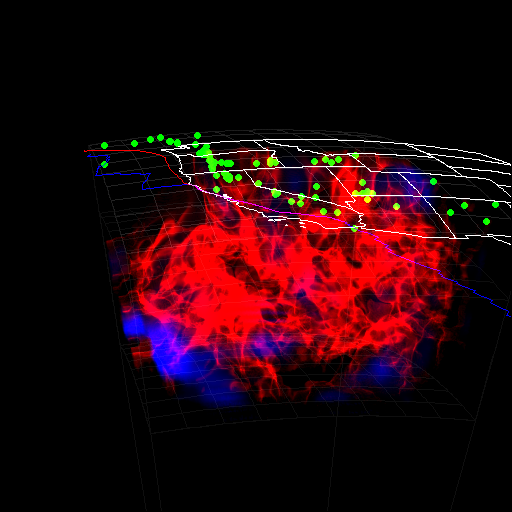

In [12]:
sc.show(sigma_clip=1.5)

### Transfer Functions: Customization

The transfer function object is a 4D numpy array of RGBa values, and so it is possible to calculate the transfer functions in any way the user sees fit. Here, we demonstrate a more complex transfer function built to clearly differentiate slow and fast anomalies in the data: two separate segments of the data use entirely different colormaps and the transmission coefficient is inversely proportional to the amount of data present. This transfer function allows us to render a wider data range without overwhelming the image with the anomalies near 0.

In [10]:
def plotTf(tfOb):
    """ create a histogram-transfer function plot and display it"""
    f=plt.figure()
    ax=plt.axes()
    ax=tfOb.addHist(ax=ax,density=True,color=(0.,0.,0.,1.))
    ax=tfOb.addTFtoPlot(ax=ax)
    ax.set_xlabel('dvs')        
    plt.show()

Now that we have a way to visualize transfer functions, we can 

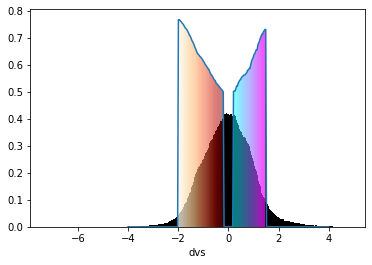

Ready to build scene


In [11]:
# setting up transfer functions 
tfOb = TFs.dv(data[datafld].ravel(),bounds=[-4,4])

def alphaHist(histData,maxAlpha,alphaFac):
    if alphaFac>maxAlpha:
        alphaFac=maxAlpha
    return maxAlpha - alphaFac*histData/histData.max()

bnds=[-2,-.2]
TFseg=TFs.TFsegment(tfOb,bounds=bnds,cmap='OrRd')
histData,_=tfOb.calcHist(bin_edges=TFseg.dvbins)
tfOb.addTFsegment(alphaHist(histData,.8,0.3),TFseg)

bnds=[.2,1.5]
TFseg=TFs.TFsegment(tfOb,bounds=bnds,cmap='cool')
histData,_=tfOb.calcHist(bin_edges=TFseg.dvbins)
tfOb.addTFsegment(alphaHist(histData,.8,0.3),TFseg)

plotTf(tfOb)
print("Ready to build scene")


In [12]:
# build scene, apply camera settings, set the transfer function 
sc = configure_scene(tfOb.tf)

Scene ready to render


yt : [INFO     ] 2020-05-06 16:52:12,301 Rendering scene (Can take a while).
yt : [INFO     ] 2020-05-06 16:52:12,587 Creating volume
/home/chavlin/miniconda3/envs/yt_seis/lib/python3.8/site-packages/yt/units/yt_array.py:1396: RuntimeWarning: invalid value encountered in log10
  out_arr = func(np.asarray(inp), out=out, **kwargs)


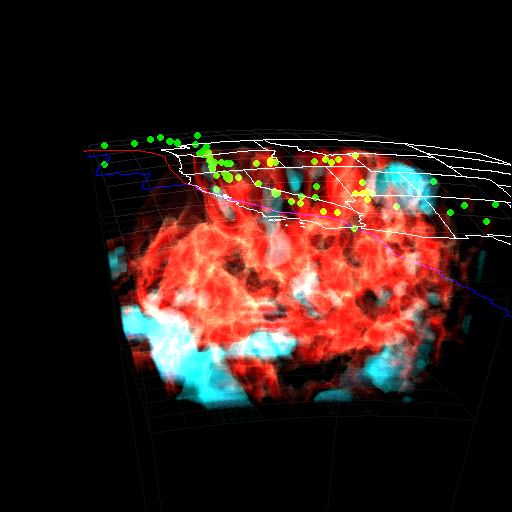

In [13]:
# actually render the scene 
sc.show(sigma_clip=1)

## References

* yt: https://yt-project.org 
* yt_seismic: https://github.com/chrishavlin/yt_seismic
* IRIS EMC: 
* full velo model refs: 
